**Import Depencencies**

In [2]:
# %pip install pandas as pd
# %pip install numpy as np
# %pip install scikit-learn
# %pip install matplotlib.pyplot as plt
# %pip install seaborn

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt


**Create DataFrame**

Import CSVs

In [4]:
# SHIPPING DASHBOARD CSV
shipments_df = pd.read_csv("./shipments_2023.csv")

# GAS PRICE AVERAGES CSV
monthly_gas_averages = pd.read_csv("./gas_averages - U.S._All_Grades_All_Formulations_Retail_Gasoline_Prices (2) (1).csv")

# CONVERT DATE COLUMN IN SHIPMENTS_DS TO DATETIME
shipments_df['Project Date'] = pd.to_datetime(shipments_df['Project Date'], format='%Y-%m-%d')

# ADJUST PROJECT DATE TO MATCH MONTHLY GAS AVG & MERGE
shipments_df['month_year'] = shipments_df['Project Date'].dt.month.astype(str) + '/' + shipments_df['Project Date'].dt.year.astype(str)
shipments_df = pd.merge(shipments_df, monthly_gas_averages, how='left', left_on='month_year', right_on='Month', suffixes=('_shipments', '_gas_averages'))
shipments_df = shipments_df.rename(columns={'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon': 'avg_gas_price'})

Create Data Frame

In [5]:
# CONVERT DATE COLUMN IN SHIPMENTS_DS TO DATETIME
shipments_df['Project Date'] = pd.to_datetime(shipments_df['Project Date'], format='%Y-%m-%d')

# MERGE NATIONAL GAS PRICE AVERAGES WITH PROJECT DATE
shipments_df['month_year'] = shipments_df['Project Date'].dt.month.astype(str) + '/' + shipments_df['Project Date'].dt.year.astype(str)
shipments_df = pd.merge(shipments_df, monthly_gas_averages, how='left', left_on='month_year', right_on='Month')
# shipments_df = shipments_df.rename(columns={'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon': 'avg_gas_price'})

# OUTBOUND
outbound_columns = ['Outbound # of Pallets', 'Outbound Total Weight (in lbs)', 'Outbound Type of Truck', 'Price Quoted for Outbound', 'One Way Distance To/From Warehouse', 'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon']
outbound_df = shipments_df[outbound_columns].copy()
outbound_df = outbound_df[outbound_df['Outbound Type of Truck'] == 'LTL']

# INBOUND
inbound_columns = ['Return # of Pallets', 'Return Total Weight', 'Return Type of Truck', 'Price Quoted for Return', 'One Way Distance To/From Warehouse', 'U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon']
inbound_df = shipments_df[inbound_columns].copy()
inbound_df = inbound_df[inbound_df['Return Type of Truck'] == 'LTL']

#CREATE WORKING DF
df = pd.DataFrame()
df['pallets'] = pd.concat([outbound_df['Outbound # of Pallets'], inbound_df['Return # of Pallets']], ignore_index=True)
df['weight'] = pd.concat([outbound_df['Outbound Total Weight (in lbs)'], inbound_df['Return Total Weight']], ignore_index=True)
df['distance'] = pd.concat([outbound_df['One Way Distance To/From Warehouse'], inbound_df['One Way Distance To/From Warehouse']], ignore_index=True)
df['avg_gas_price'] = pd.concat([outbound_df['U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon'], inbound_df['U.S. All Grades All Formulations Retail Gasoline Prices Dollars per Gallon']], ignore_index=True)
df['quote'] = pd.concat([outbound_df['Price Quoted for Outbound'], inbound_df['Price Quoted for Return']], ignore_index=True)

# CLEAN UP COLUMNS
df['weight'] = df['weight'].str.replace(',', '').str.replace(' lbs', '').astype(int)
df['distance'] = df['distance'].str.replace(',', '').str.replace(' miles', '').astype(float)
df['quote'] = df['quote'].str.replace("$", '').str.replace(',', '').astype(float)
df = df.dropna(axis=0)

print(df)


    pallets  weight  distance  avg_gas_price    quote
0         3    4100      89.0          3.445   510.00
1         3    4000     936.0          3.445   925.17
2         3    4100     747.0          3.445   921.33
3         6    8800     799.0          3.445  1656.31
4         4    5000     960.0          3.445  1198.72
..      ...     ...       ...            ...      ...
157       3    3000     747.0          3.257   941.33
158       2    1800     907.0          3.257   653.73
159       2    1000    2200.0          3.257   693.87
160       4    2800    1832.0          3.257  1299.09
161       3    2600     955.0          3.257   984.56

[159 rows x 5 columns]


**Train Model**

In [6]:
# INDEPENDENT VARIABLES
X = df[['pallets', 'weight', 'distance', 'avg_gas_price']]

# DEPENDENT VARIABLE
y = df['quote']

# SPLIT DATASET
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

# TRAINING MODEL
regressor = LinearRegression()
regressor.fit(X_train,y_train)

# VALIDATING MODEL
y_pred = regressor.predict(X_test)

Comparing Actual vs Predicted data points

In [7]:
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
# pd.set_option('display.max_rows', None)


print(df.head())

      Actual    Predicted
7    1078.34  1026.947831
40   1224.49  1086.700525
96    541.24   703.009078
45   1800.00  1777.695627
111   653.16   795.712302


Graph Results

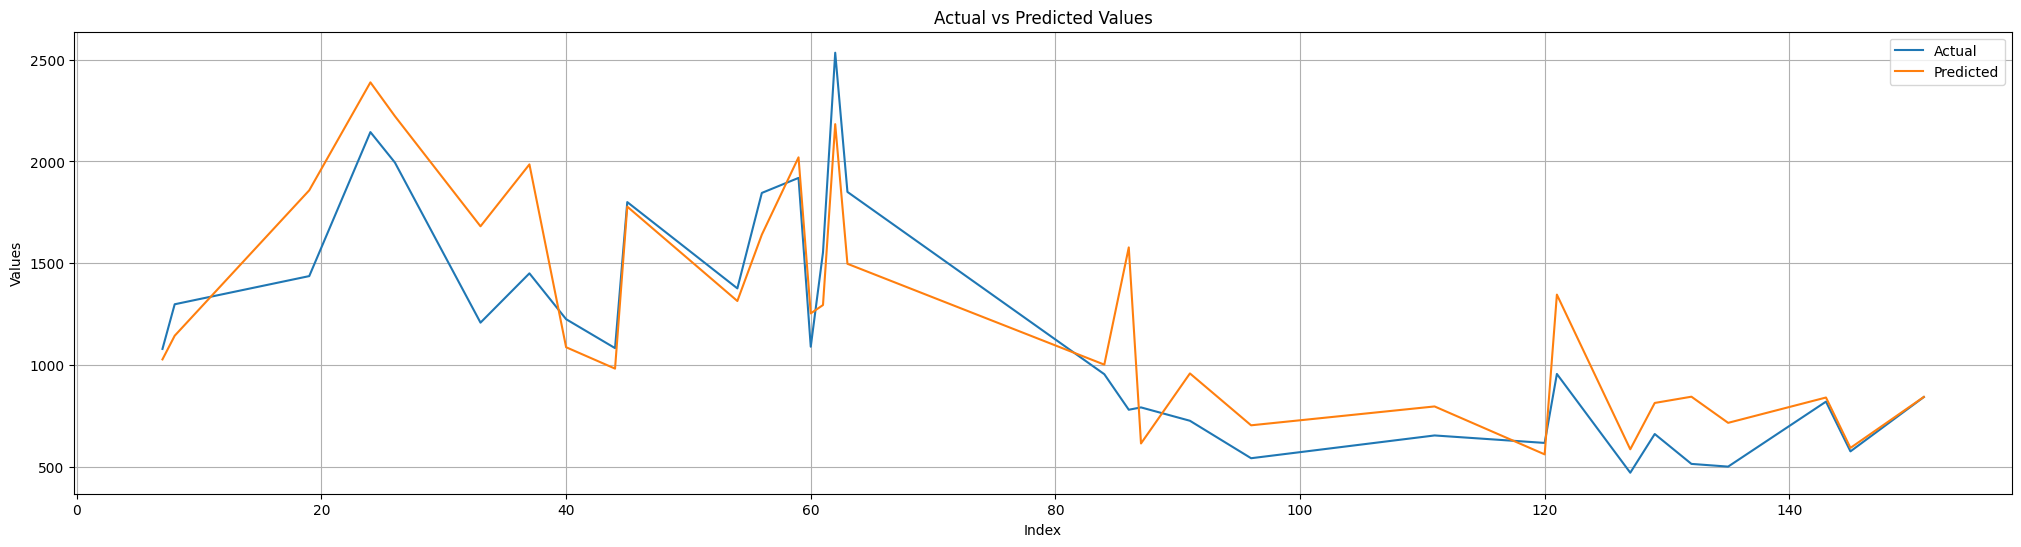

In [8]:
df.sort_index(inplace=True)

# Plotting without dots
plt.figure(figsize=(25, 6))
plt.plot(df.index, df['Actual'], label='Actual', marker='')
plt.plot(df.index, df['Predicted'], label='Predicted', marker='')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

View Coefficients & How the model is doing overall

In [ ]:
print("Intercept (b0):", regressor.intercept_)
print("Coefficients (b1, b2, b3, b4): ", regressor.coef_)

In [ ]:
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))